#Lab 6: Dense Stereo
In this lab, you will implement window-based stereo and scan-line stereo given two images. You will also get faimilar with the trick of integral image to accelerate window-based stereo algorithm.

Related lecture note: http://mengtang.org/cse185/files/lec09_2_stereo.pdf

(-0.5, 383.5, 287.5, -0.5)

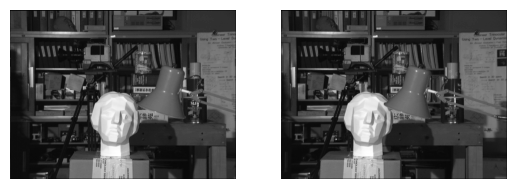

In [1]:
# read left image and right image
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

import urllib.request
urllib.request.urlretrieve("http://mengtang.org/cse185/files/resource/stereo_left.ppm", "stereo_left.ppm")
urllib.request.urlretrieve("http://mengtang.org/cse185/files/resource/stereo_right.ppm", "stereo_right.ppm")

imL = image.imread("stereo_left.ppm")
imR = image.imread("stereo_right.ppm")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)
plt.subplot(1,2,1)
plt.imshow(imLgray, cmap='gray')
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(imRgray, cmap='gray')
plt.axis("off")

##Part 1: Window-based stereo
Complete the function windowed_stereo bellow which computes stereo based on sum of differences of two windows on the left and right images.

In [3]:
def windowed_stereo(imgL, imgR, max_disparity=30, window_size=7):

    W = imgL.shape[1];
    H = imgL.shape[0];
    window_half_size = window_size //2
    # create the disparities image:
    Disparities = np.zeros([H, W]);

    # loop over the image
    for x in np.arange(window_half_size, W-window_half_size):

        # in the left border of the left image, not all disparities can be investigated:
        max_disp = np.min([x-window_half_size, max_disparity]);
        if(max_disp >= 0):
            disps = np.arange(0, max_disp+1);
            differences = np.zeros([len(disps), 1]);

            for y in np.arange(window_half_size, H-window_half_size):

                window_left = imgL[y - window_half_size:y + window_half_size + 1, x - window_half_size:x + window_half_size + 1]

                for d in disps:
                    window_right = imgR[y - window_half_size:y + window_half_size + 1, x - window_half_size - d:x + window_half_size - d + 1]
                    differences[d] = np.sum(np.abs(window_left - window_right)) # sum of differences between windows

                # the minimal difference determines the disparity
                disparity = np.argmin(differences) # disparity is min difference
                Disparities[y, x] = disparity;

    return Disparities;

Visualze disparity map, experiment with different window size(window_size=3,5 or 7), and see the different results obtained. Measure the time it takes to compute stereo.

It takes 17.13249969482422 seconds to compute stereo!


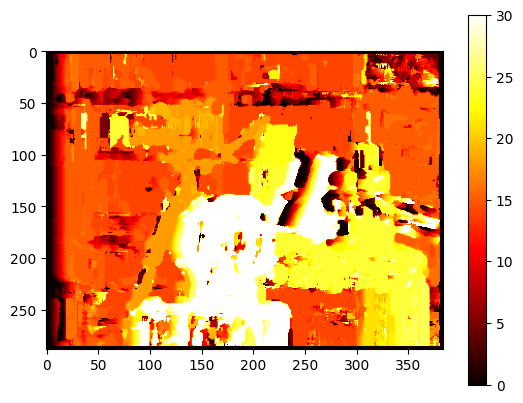

In [4]:
import time

start=time.time()
disparity_map = windowed_stereo(imLgray, imRgray, max_disparity=30, window_size=7);
print(f"It takes {time.time()-start} seconds to compute stereo!")
plt.figure();
plt.imshow(disparity_map, cmap='hot');
plt.colorbar();
plt.draw()

Implement a fast version of the window-based stereo algorithm by using integral image. Measure the speedup compared to naive implementation.

It takes 4.011498212814331 seconds to compute stereo using the trick of integral image!


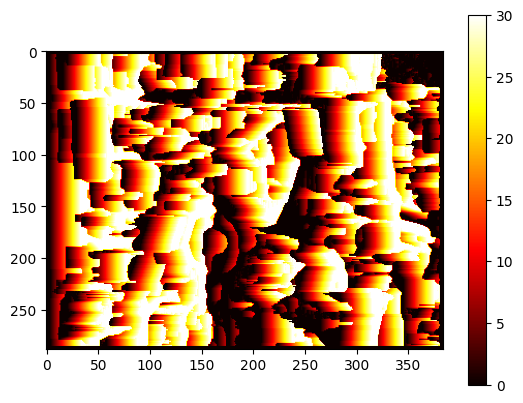

In [6]:
def windowed_stereo_fast(imgL, imgR, max_disparity=30, window_size=7):

    W = imgL.shape[1];
    H = imgL.shape[0];
    window_half_size = window_size //2
    # create the disparities image:
    Disparities = np.zeros([H, W]);

    # integral imgs
    integral_imgL = np.cumsum(np.cumsum(imgL, axis=0), axis=1)
    integral_imgR = np.cumsum(np.cumsum(imgR, axis=0), axis=1)

    for x in range(window_half_size, W - window_half_size):
        max_disp = min(x - window_half_size, max_disparity)
        if max_disp >= 0:
            disps = np.arange(0, max_disp + 1)
            diffs = np.zeros([len(disps), 1])

            for y in range(window_half_size, H - window_half_size):
                integral_window_left = integral_imgL[y + window_half_size, x + window_half_size] \
                            - integral_imgL[y - window_half_size, x + window_half_size] \
                            - integral_imgL[y + window_half_size, x - window_half_size] \
                            + integral_imgL[y - window_half_size, x - window_half_size]

                for d in disps:
                    integral_window_right = integral_imgR[y + window_half_size, x - window_half_size - d] \
                                - integral_imgR[y - window_half_size, x - window_half_size - d] \
                                - integral_imgR[y + window_half_size, x + window_half_size - d] \
                                + integral_imgR[y - window_half_size, x + window_half_size - d]

                    diffs[d] = abs(integral_window_left - integral_window_right)

                disparity = np.argmin(diffs)
                Disparities[y, x] = disparity

    return Disparities;

start=time.time()
disparity_map = windowed_stereo_fast(imLgray, imRgray, max_disparity=30, window_size=7);
print(f"It takes {time.time()-start} seconds to compute stereo using the trick of integral image!")
plt.figure();
plt.imshow(disparity_map, cmap='hot');
plt.colorbar();
plt.draw()

##Part 2: Scan-line stereo
Implement scan-line stereo using dynamic programming. The optimization objective is the sum of a data term and a pairwise regularization term.

$E(d)=\sum_{p\in S}D_p(d_p)+ w\cdot \sum_{p\in S}V_p(d_p,d_{p+1})$

where $D_p(d_p) = |I^{right}_p - I^{left}_{p+d_p}|$ is a photo-consistency term and $V_p(d_p, d_{p+1})$ is a pairwise regularization term.

Experiment with different weight $w$ of the regularization term.

In [15]:
import numpy as np
import time
import matplotlib.pyplot as plt

def scanline_stereo(imgL, imgR, max_disparity, w):
    W = imgL.shape[1]
    H = imgL.shape[0]
    Disparities = np.zeros([H, W], dtype=int)

    # Calculate the data term, D_p(d_p), for all disparities and pixels
    data_term = np.zeros((H, W, max_disparity))
    for d in range(max_disparity):
        shifted_imgR = np.roll(imgR, shift=d, axis=1)
        data_term[:, :, d] = np.abs(imgL - shifted_imgR)

    # Initialize the dynamic programming table
    dp_table = [np.zeros((W, max_disparity), dtype=float) for _ in range(H)]
    dp_table[0] = data_term[0]

    # Dynamic programming to compute the disparity map
    for y in range(1, H):
        for x in range(W):
            for d in range(max_disparity):
                # Compute the energy for each disparity value
                energy = data_term[y, x, d] + dp_table[y - 1][x, d]
                if d > 0:
                    # Compute the pairwise regularization term
                    energy += w * np.abs(d - 1 - np.arange(max_disparity)) + dp_table[y - 1][x, d - 1]
                dp_table[y][x, d] = energy

    # Backtrack to find the disparity map
    Disparities[-1, -1] = np.argmin(dp_table[-1][-1, :])
    for y in range(H - 1, 0, -1):
        for x in range(W - 1, 0, -1):
            prev_disparity = Disparities[y, x]
            if x > 0:
                neighbor_disparities = np.arange(max(0, prev_disparity - 1), min(max_disparity, prev_disparity + 2))
                min_disparity = np.argmin(dp_table[y - 1][x - 1, neighbor_disparities])
                Disparities[y, x - 1] = neighbor_disparities[min_disparity]

    return Disparities

# Example usage
start = time.time()
disparity_map = scanline_stereo(imLgray, imRgray, max_disparity=30, w=2)
print(f"It takes {time.time() - start} seconds to compute scan-line stereo!")
plt.figure()
plt.imshow(disparity_map, cmap='hot')
plt.colorbar()
plt.show()


ValueError: setting an array element with a sequence.